## Redes Neuronales Convolucionales con PyTorch

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
#only if you have jupyterthemes
from jupyterthemes import jtplot
jtplot.style()

### Descargar Cifar10 dataset

In [4]:
DATA_PATH = '/media/josh/MyData2SSD/Databases/cifar-10-batches-py'
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Train dataset
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_cifar)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
#Validation set
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                           transform=transform_cifar)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))
#Test set
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_cifar)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /media/josh/MyData2SSD/Databases/cifar-10-batches-py
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [6]:
test_loader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /media/josh/MyData2SSD/Databases/cifar-10-batches-py
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

### Usar GPUs

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Mostrar imágenes

La imagen muestreada representa un: ship


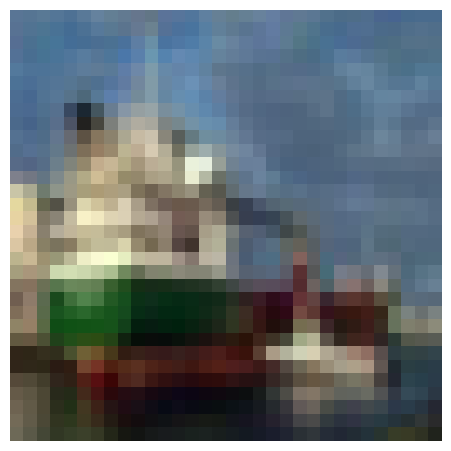

In [8]:
classes = test_loader.dataset.classes
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)


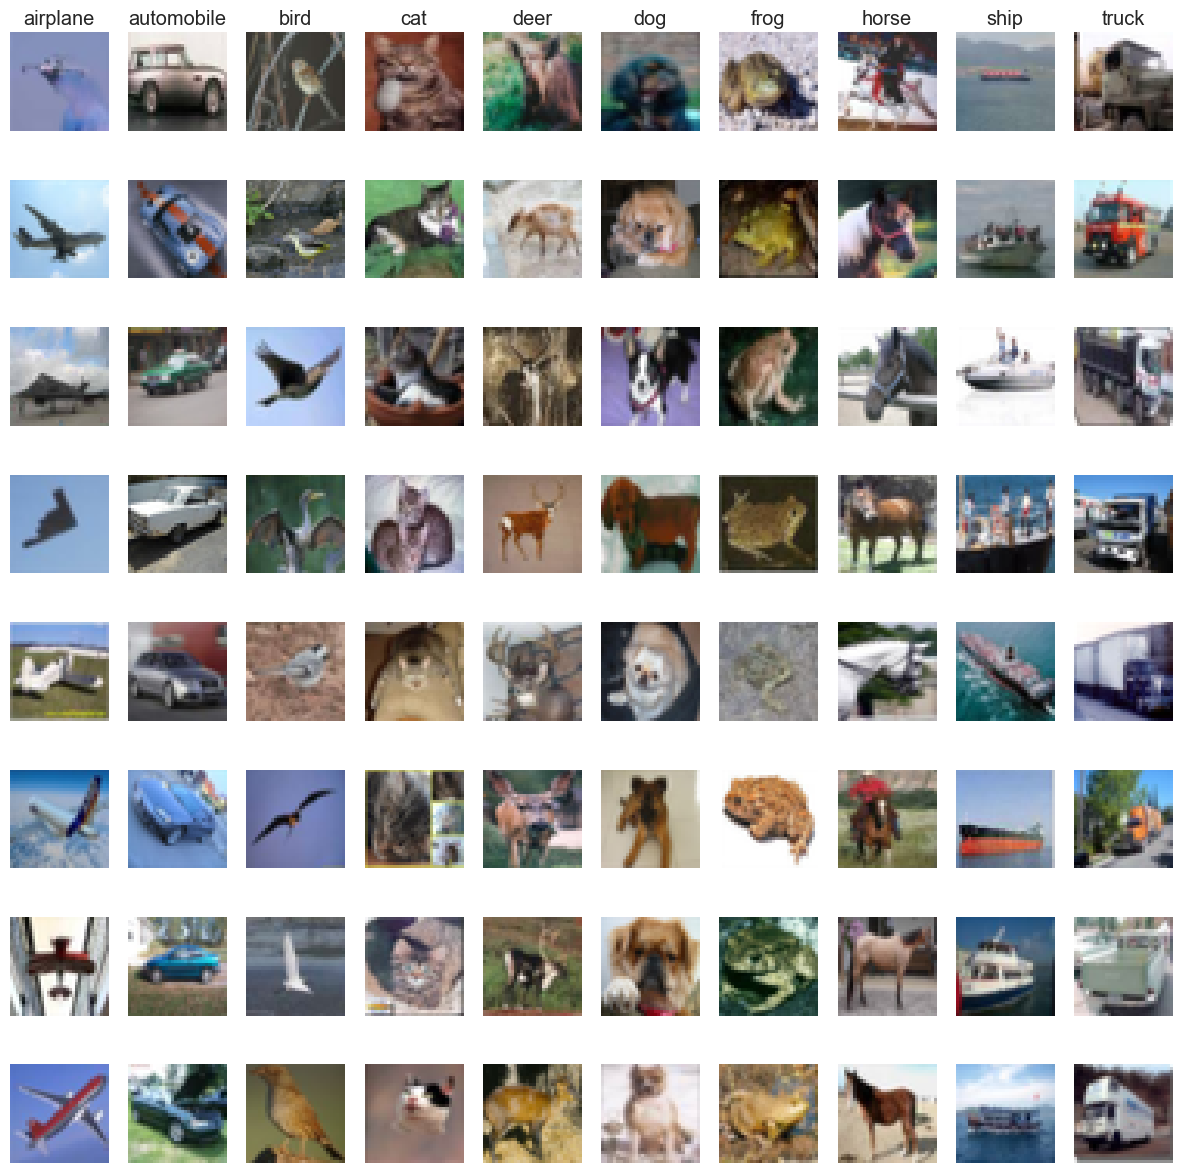

In [9]:
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid() 

### Calcular accuracy


In [10]:
for i, (x,y) in enumerate(test_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 32, 32]) torch.Size([64])
1 torch.Size([64, 3, 32, 32]) torch.Size([64])
2 torch.Size([64, 3, 32, 32]) torch.Size([64])
3 torch.Size([64, 3, 32, 32]) torch.Size([64])
4 torch.Size([64, 3, 32, 32]) torch.Size([64])
5 torch.Size([64, 3, 32, 32]) torch.Size([64])
6 torch.Size([64, 3, 32, 32]) torch.Size([64])
7 torch.Size([64, 3, 32, 32]) torch.Size([64])
8 torch.Size([64, 3, 32, 32]) torch.Size([64])
9 torch.Size([64, 3, 32, 32]) torch.Size([64])
10 torch.Size([64, 3, 32, 32]) torch.Size([64])
11 torch.Size([64, 3, 32, 32]) torch.Size([64])
12 torch.Size([64, 3, 32, 32]) torch.Size([64])
13 torch.Size([64, 3, 32, 32]) torch.Size([64])
14 torch.Size([64, 3, 32, 32]) torch.Size([64])
15 torch.Size([64, 3, 32, 32]) torch.Size([64])
16 torch.Size([64, 3, 32, 32]) torch.Size([64])
17 torch.Size([64, 3, 32, 32]) torch.Size([64])
18 torch.Size([64, 3, 32, 32]) torch.Size([64])
19 torch.Size([64, 3, 32, 32]) torch.Size([64])
20 torch.Size([64, 3, 32, 32]) torch.Size([64])
21

In [11]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) 
            _, pred = scores.max(dim=1) 
            num_correct += (pred == yi).sum() 
            num_total += pred.size(0)
        return float(num_correct)/num_total   

### Loop de entrenamiento

In [12]:
def train(model, optimiser, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            cost = F.cross_entropy(input= scores, target=yi)
            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()              
        acc = accuracy(model, val_loader) 
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')

### Sequential linear

In [13]:
hidden1 = 256 
hidden = 256
lr = 0.001
epochs = 10
model1 = nn.Sequential(nn.Flatten(),
                       nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr)

In [14]:
train(model1, optimiser, epochs)

Epoch: 0, costo: 1.1776347160339355, accuracy: 0.468,
Epoch: 1, costo: 1.222986102104187, accuracy: 0.4832,
Epoch: 2, costo: 1.6244570016860962, accuracy: 0.5154,
Epoch: 3, costo: 1.595521330833435, accuracy: 0.5292,
Epoch: 4, costo: 1.0675649642944336, accuracy: 0.5318,
Epoch: 5, costo: 1.3749091625213623, accuracy: 0.528,
Epoch: 6, costo: 0.9350227117538452, accuracy: 0.5352,
Epoch: 7, costo: 0.8686823844909668, accuracy: 0.5348,
Epoch: 8, costo: 0.8929226994514465, accuracy: 0.5374,
Epoch: 9, costo: 0.8913057446479797, accuracy: 0.5312,


### Sequential CNN

In [15]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 0.0001
modelCNN1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=channel1, 
                                   kernel_size=3, padding=1),
                          nn.ReLU(),
                          nn.Conv2d(in_channels=channel1, out_channels=channel2,
                                    kernel_size= 3, padding=1),
                          nn.ReLU(),
                          nn.MaxPool2d(2, 2),
                          nn.Flatten(),
                          nn.Linear(in_features=16*16*channel2, out_features=10)                        
                                   )
optimiser = torch.optim.Adam(modelCNN1.parameters(), lr)

In [16]:
train(modelCNN1, optimiser, epochs)

Epoch: 0, costo: 1.7154046297073364, accuracy: 0.4614,
Epoch: 1, costo: 1.1833813190460205, accuracy: 0.5176,
Epoch: 2, costo: 1.5360926389694214, accuracy: 0.554,
Epoch: 3, costo: 1.7718758583068848, accuracy: 0.5722,
Epoch: 4, costo: 1.5324479341506958, accuracy: 0.6042,
Epoch: 5, costo: 1.3064626455307007, accuracy: 0.6116,
Epoch: 6, costo: 1.1280471086502075, accuracy: 0.6166,
Epoch: 7, costo: 1.0346275568008423, accuracy: 0.6268,
Epoch: 8, costo: 0.8626739978790283, accuracy: 0.6384,
Epoch: 9, costo: 0.8332452774047852, accuracy: 0.6336,


### OOP 

In [17]:
class CNN_class1(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channel, out_channels = channel1,
                              kernel_size=3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = channel1, out_channels = channel2,
                              kernel_size=3, padding=1)
        self.max_pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(in_features=16*16*channel2, out_features=10)
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = F.relu(self.conv2(F.relu(self.conv1(x))))
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.fc(x)

In [18]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 0.0001
modelCNN2 = CNN_class1(3, channel1, channel2)
optimiser = torch.optim.Adam(modelCNN2.parameters(), lr)

In [19]:
train(modelCNN2, optimiser, epochs)

Epoch: 0, costo: 1.6398082971572876, accuracy: 0.4716,
Epoch: 1, costo: 1.6351921558380127, accuracy: 0.521,
Epoch: 2, costo: 1.227703332901001, accuracy: 0.5464,
Epoch: 3, costo: 1.2031545639038086, accuracy: 0.5672,
Epoch: 4, costo: 1.092008113861084, accuracy: 0.5726,
Epoch: 5, costo: 1.144577980041504, accuracy: 0.5876,
Epoch: 6, costo: 0.8173632621765137, accuracy: 0.597,
Epoch: 7, costo: 1.0174078941345215, accuracy: 0.6086,
Epoch: 8, costo: 0.99697345495224, accuracy: 0.6098,
Epoch: 9, costo: 1.1311464309692383, accuracy: 0.6162,


### Un poco más elegante

In [20]:
conv_k_3 = lambda channel1, channel2: nn.Conv2d(channel1, channel2, kernel_size=3, padding=1)

In [21]:
class CNN_class2(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        self.conv1 = conv_k_3(in_channel, channel1)
        nn.init.kaiming_uniform_(self.conv1.weight)

        self.conv2 = conv_k_3(channel1, channel2)
        self.max_pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(in_features=16*16*channel2, out_features=10)
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = F.relu(self.conv2(F.relu(self.conv1(x))))
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.fc(x)
    

In [22]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 0.0001
modelCNN3 = CNN_class2(3, channel1, channel2)
optimiser = torch.optim.Adam(modelCNN3.parameters(), lr)

In [23]:
train(modelCNN3, optimiser, epochs)

Epoch: 0, costo: 1.5337704420089722, accuracy: 0.5108,
Epoch: 1, costo: 1.0184338092803955, accuracy: 0.5476,
Epoch: 2, costo: 0.9861569404602051, accuracy: 0.5746,
Epoch: 3, costo: 1.053359866142273, accuracy: 0.5932,
Epoch: 4, costo: 1.2021838426589966, accuracy: 0.606,
Epoch: 5, costo: 1.650923728942871, accuracy: 0.611,
Epoch: 6, costo: 0.7477825284004211, accuracy: 0.6294,
Epoch: 7, costo: 1.035611867904663, accuracy: 0.6296,
Epoch: 8, costo: 1.1450144052505493, accuracy: 0.6328,
Epoch: 9, costo: 0.9416249394416809, accuracy: 0.64,


In [24]:
class CNN_class3(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        self.conv1 = conv_k_3(in_channel, channel1)
        self.bn1 = nn.BatchNorm2d(channel1)

        self.conv2 = conv_k_3(channel1, channel2)
        self.bn2 = nn.BatchNorm2d(channel2)
        
        self.max_pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(in_features=16*16*channel2, out_features=10)
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.fc(x)

In [25]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 0.0001
modelCNN4 = CNN_class3(3, channel1, channel2)
optimiser = torch.optim.Adam(modelCNN4.parameters(), lr)

In [26]:
train(modelCNN4, optimiser, epochs)

Epoch: 0, costo: 0.9261568784713745, accuracy: 0.559,
Epoch: 1, costo: 1.0871994495391846, accuracy: 0.6148,
Epoch: 2, costo: 1.196853518486023, accuracy: 0.6416,
Epoch: 3, costo: 0.6911175847053528, accuracy: 0.6386,
Epoch: 4, costo: 0.4060076177120209, accuracy: 0.6528,
Epoch: 5, costo: 1.2546154260635376, accuracy: 0.6504,
Epoch: 6, costo: 0.9405676126480103, accuracy: 0.6584,
Epoch: 7, costo: 0.7147588133811951, accuracy: 0.6528,
Epoch: 8, costo: 0.6603730320930481, accuracy: 0.6742,
Epoch: 9, costo: 0.7161851525306702, accuracy: 0.659,


In [27]:
class CNN_class4(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        self.conv1 = conv_k_3(in_channel, channel1)
        self.bn1 = nn.BatchNorm2d(channel1)

        self.conv2 = conv_k_3(channel1, channel2)
        self.bn2 = nn.BatchNorm2d(channel2)
        
        self.max_pool = nn.MaxPool2d(2,2)

    def forward(self, x):
        x = F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))
        return self.max_pool(x)

In [28]:
channel1 = 16
channel2 = 32
channel3 = 64
channel4 = 128
epochs = 10
lr = 0.001
modelCNN5 = nn.Sequential(CNN_class4(3,channel1, channel2),
                          CNN_class4(channel2, channel4, channel4),
                          nn.Flatten(),
                          nn.Linear(in_features=8*8*channel4, out_features=10))

optimiser = torch.optim.Adam(modelCNN5.parameters(), lr)

In [29]:
train(modelCNN5, optimiser, epochs)

Epoch: 0, costo: 1.3729701042175293, accuracy: 0.6646,
Epoch: 1, costo: 1.8747165203094482, accuracy: 0.744,
Epoch: 2, costo: 0.5746091604232788, accuracy: 0.753,
Epoch: 3, costo: 0.4716338813304901, accuracy: 0.7544,
Epoch: 4, costo: 0.3710656464099884, accuracy: 0.7588,
Epoch: 5, costo: 0.3773827850818634, accuracy: 0.7916,
Epoch: 6, costo: 0.15770454704761505, accuracy: 0.7998,
Epoch: 7, costo: 0.33279314637184143, accuracy: 0.7944,
Epoch: 8, costo: 0.49442756175994873, accuracy: 0.7922,
Epoch: 9, costo: 0.10292882472276688, accuracy: 0.7864,


In [30]:
accuracy(modelCNN5, test_loader)

0.7854